In [1]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("./experiments/summary.csv").drop("run_id", axis=1)

for col in ["sweep_value", "pr_auc", "recall_anomaly", "precision_anomaly", "f1_anomaly", "accuracy"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

df

,sweep_key,sweep_value,model_name,seed,n_samples,anomaly_ratio,label_noise,pr_auc,recall_anomaly,precision_anomaly,f1_anomaly,accuracy,tn,fp,fn,tp
0,anomaly_ratio,0.01,vqc_4,2,1000,0.01,0.05,0.047199,0.058824,0.017544,0.027027,0.760000,227,56,16,1
1,anomaly_ratio,0.01,vqc_3,2,1000,0.01,0.05,0.054941,0.000000,0.000000,0.000000,0.900000,270,13,17,0
2,anomaly_ratio,0.01,vqc_2,2,1000,0.01,0.05,0.077967,0.000000,0.000000,0.000000,0.943333,283,0,17,0
3,anomaly_ratio,0.01,random_forest,2,1000,0.01,0.05,0.162177,0.058824,1.000000,0.111111,0.946667,283,0,16,1
4,anomaly_ratio,0.01,svm,2,1000,0.01,0.05,0.319157,0.000000,0.000000,0.000000,0.943333,283,0,17,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,label_noise,0.10,vqc_3,0,1000,0.05,0.10,0.453680,0.162791,1.000000,0.280000,0.880000,257,0,36,7
296,label_noise,0.10,vqc_2,0,1000,0.05,0.10,0.222874,0.000000,0.000000,0.000000,0.856667,257,0,43,0
297,label_noise,0.10,random_forest,0,1000,0.05,0.10,0.493837,0.325581,0.823529,0.466667,0.893333,254,3,29,14
298,label_noise,0.10,svm,0,1000,0.05,0.10,0.538698,0.302326,1.000000,0.464286,0.900000,257,0,30,13


In [2]:
agg = (
    df.groupby(["sweep_key", "sweep_value", "model_name"], as_index=False)
      .agg(
          pr_auc_mean=("pr_auc", "mean"),
          pr_auc_std=("pr_auc", "std"),
          recall_mean=("recall_anomaly", "mean"),
          recall_std=("recall_anomaly", "std"),
          f1_mean=("f1_anomaly", "mean"),
          f1_std=("f1_anomaly", "std"),
      )
)

agg = agg.sort_values(["sweep_key", "sweep_value", "model_name"])
agg.head()

,sweep_key,sweep_value,model_name,pr_auc_mean,pr_auc_std,recall_mean,recall_std,f1_mean,f1_std
0,anomaly_ratio,0.01,random_forest,0.213321,0.052190,0.113725,0.057325,0.188782,0.088124
1,anomaly_ratio,0.01,svm,0.242810,0.093024,0.033987,0.031054,0.063275,0.057895
2,anomaly_ratio,0.01,vqc_1,0.068087,0.029782,0.228758,0.108583,0.075528,0.036338
3,anomaly_ratio,0.01,vqc_2,0.061449,0.011146,0.000000,0.000000,0.000000,0.000000
4,anomaly_ratio,0.01,vqc_3,0.076317,0.018457,0.011111,0.024845,0.014286,0.031944


In [3]:
def plot_sweep(agg, sweep_key, y_mean_col, y_std_col, ylabel, title, add_baseline=False):
    sub = agg[agg["sweep_key"] == sweep_key].copy()
    if sub.empty:
        print(f"No data found for sweep_key={sweep_key}")
        return
    
    x_vals = sorted(sub["sweep_value"].unique())

    plt.figure()
    for model in sorted(sub["model_name"].unique()):
        m = sub[sub["model_name"] == model].sort_values("sweep_value")
        plt.errorbar(
            m["sweep_value"],
            m[y_mean_col],
            yerr=m[y_std_col].fillna(0),
            marker="o",
            capsize=3,
            label=model,
        )

    # Optional: PR-AUC baseline for anomaly_ratio sweep
    if add_baseline and sweep_key == "anomaly_ratio":
        plt.plot(x_vals, x_vals, linestyle="--", label="random baseline (PR-AUC ≈ anomaly_ratio)")

    plt.xlabel(sweep_key)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

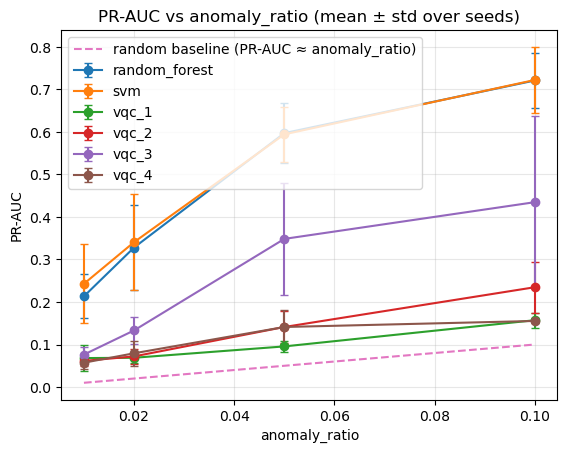

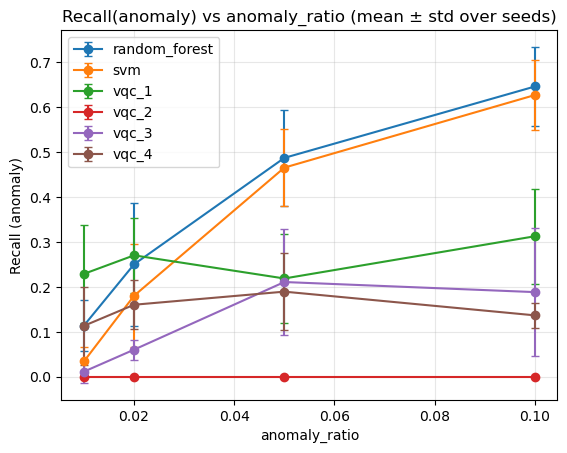

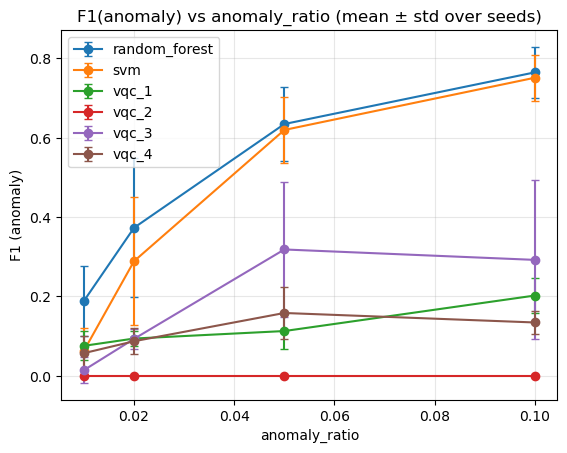

In [4]:
plot_sweep(
    agg, "anomaly_ratio",
    "pr_auc_mean", "pr_auc_std",
    ylabel="PR-AUC",
    title="PR-AUC vs anomaly_ratio (mean ± std over seeds)",
    add_baseline=True
)

plot_sweep(
    agg, "anomaly_ratio",
    "recall_mean", "recall_std",
    ylabel="Recall (anomaly)",
    title="Recall(anomaly) vs anomaly_ratio (mean ± std over seeds)"
)

plot_sweep(
    agg, "anomaly_ratio",
    "f1_mean", "f1_std",
    ylabel="F1 (anomaly)",
    title="F1(anomaly) vs anomaly_ratio (mean ± std over seeds)"
)

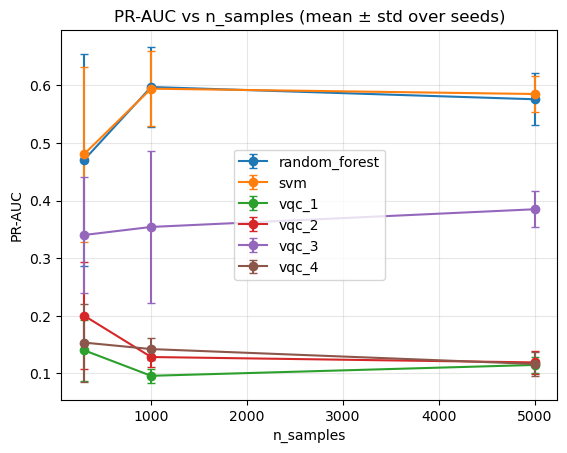

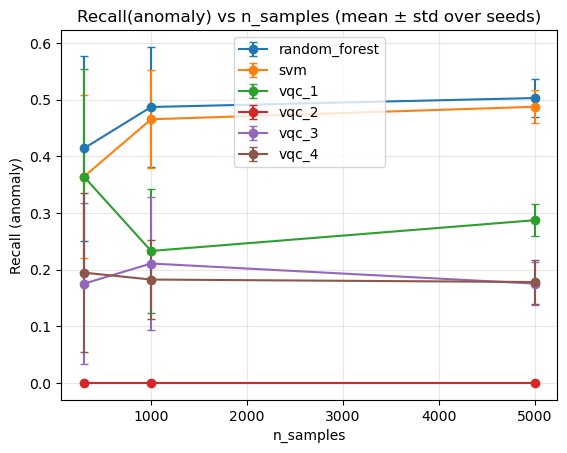

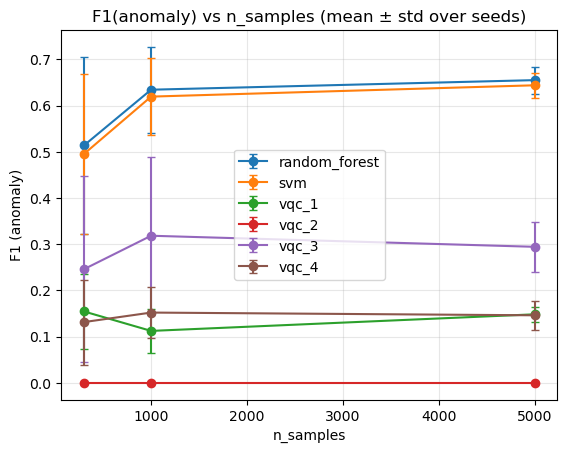

In [5]:
plot_sweep(
    agg, "n_samples",
    "pr_auc_mean", "pr_auc_std",
    ylabel="PR-AUC",
    title="PR-AUC vs n_samples (mean ± std over seeds)",
    add_baseline=True
)

plot_sweep(
    agg, "n_samples",
    "recall_mean", "recall_std",
    ylabel="Recall (anomaly)",
    title="Recall(anomaly) vs n_samples (mean ± std over seeds)"
)

plot_sweep(
    agg, "n_samples",
    "f1_mean", "f1_std",
    ylabel="F1 (anomaly)",
    title="F1(anomaly) vs n_samples (mean ± std over seeds)"
)

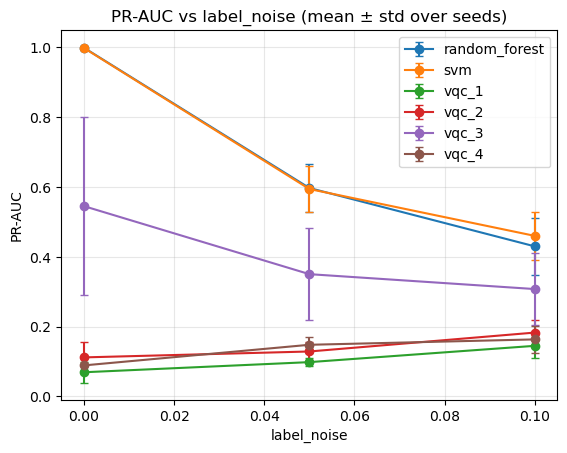

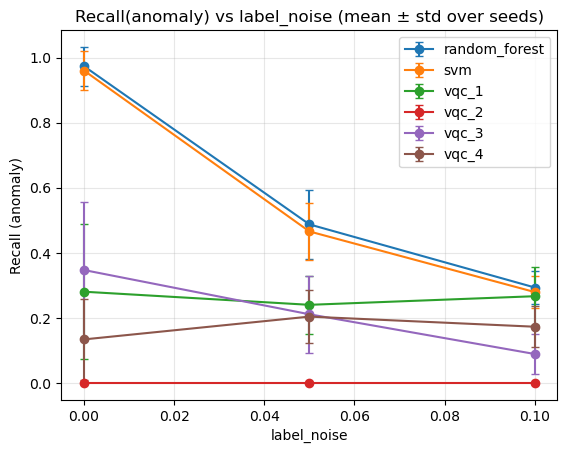

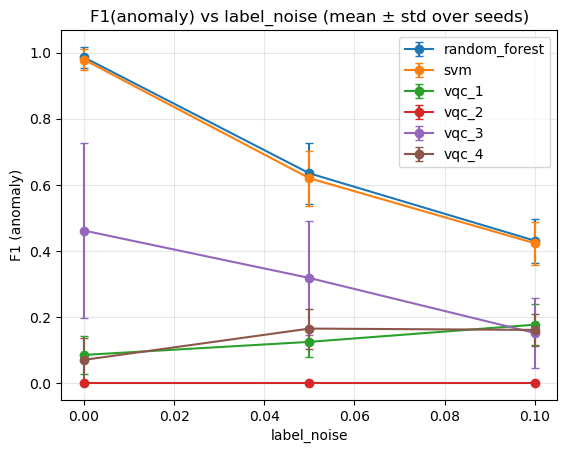

In [6]:
plot_sweep(
    agg, "label_noise",
    "pr_auc_mean", "pr_auc_std",
    ylabel="PR-AUC",
    title="PR-AUC vs label_noise (mean ± std over seeds)",
    add_baseline=True
)

plot_sweep(
    agg, "label_noise",
    "recall_mean", "recall_std",
    ylabel="Recall (anomaly)",
    title="Recall(anomaly) vs label_noise (mean ± std over seeds)"
)

plot_sweep(
    agg, "label_noise",
    "f1_mean", "f1_std",
    ylabel="F1 (anomaly)",
    title="F1(anomaly) vs label_noise (mean ± std over seeds)"
)